In [5]:
import sys, os
import datetime as dt
import pandas as pd
import glob
url = "https://www.pge.com/pge_global/forms/mads/profiles"

In [2]:
# retrieve archive data
today = dt.datetime.now()
for year in range(1999,today.year):
    file = f"{year}dlp"
    if not os.path.exists("dlp"):
        os.mkdir("dlp")
    if not os.path.exists(f"dlp/{file}.zip"):
        if not os.path.exists(f"dlp/{file}.zip"):
            os.system(f"curl {url}/archive/{file}.zip > dlp/{file}.zip")
            os.system(f"unzip -d dlp dlp/{file}.zip")

In [3]:
# retrieve data for current year
today = dt.datetime.now()
start = dt.datetime(today.year,1,1,0,0,0)
for days in range((today-start).days):
    file = (start+dt.timedelta(days)).strftime("%Y%m%d")
    if not os.path.exists(f"dlp/{file}.dlp"):
        os.system(f"curl {url}/{file}.dlp > dlp/{file}.dlp")
        data = pd.read_csv(f"dlp/{file}.dlp")
        try:
            if str(file) != str(data.columns[0]):
                raise Exception("bad dlp file")
        except:
            os.unlink(f"dlp/{file}.dlp")

In [17]:
def to_timedelta(td):
    hm = td.split(":")
    return dt.timedelta(hours=int(hm[0]),minutes=int(hm[1]))

# collate data
if os.path.exists("dlp.csv"):
    dlp = pd.read_csv("dlp.csv")
else:
    blocks = []
    for file in sorted(glob.glob("dlp/*.dlp")):
        block = pd.read_csv(file)
        if file != f"dlp/{block.columns[0]}.dlp":
            os.unlink(file)
        else:
            date = dt.datetime.strptime(file,"dlp/%Y%m%d.dlp")
            name = date.strftime('%Y%m%d')
            block = pd.read_csv(f"dlp/{name}.dlp").dropna(how='all').transpose()
            block.columns = block.loc["Profile"]
            block.drop([name,"Profile","Method"],inplace=True)
            block.index = list(map(lambda h: date+to_timedelta(h),block.index))
            blocks.append(block)
    dlp = pd.concat(blocks,sort=False,copy=False)
    dlp.to_csv("dlp.csv")

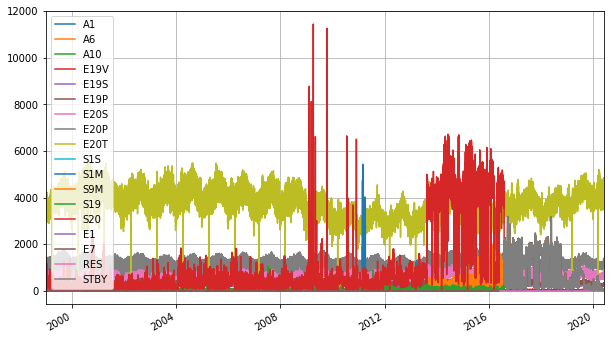

In [16]:
dlp.plot(figsize=(10,6),grid=True).get_figure().savefig("dlp.png")